In [1]:
# Libraries

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import joblib

In [5]:
import plydata.cat_tools as cat

In [6]:
import plotnine as pn

In [7]:
pn.options.dpi = 300

In [8]:
# Data preparation ==== 

In [9]:
cdnow_raw_df = pd.read_csv(
    "datasets/CDNOW_master.txt", sep = "\s+"
)

In [10]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_id    69659 non-null  int64  
 1   date           69659 non-null  int64  
 2   number_of_cds  69659 non-null  int64  
 3   dollar_value   69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [11]:
cdnow_raw_df.head(3)

,customer_id,date,number_of_cds,dollar_value
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00


In [12]:
 list(cdnow_raw_df)

['customer_id', 'date', 'number_of_cds', 'dollar_value']

In [13]:
cdnow_raw_df.columns = ['customer_id','date','quantity','price']

In [14]:
cdnow_raw_df.head(3)

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00


In [15]:
cdnow_df = cdnow_raw_df.assign(date = lambda x: x['date'].astype(str)).\
assign(date = lambda x: pd.to_datetime(x['date'])).dropna()

In [16]:
cdnow_df.head(4)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76


In [17]:
cdnow_df.sort_values(['customer_id','date']).head(10)

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
5,3,1997-04-02,2,19.54
6,3,1997-11-15,5,57.45
7,3,1997-11-25,4,20.96
8,3,1998-05-28,1,16.99
9,4,1997-01-01,2,29.33


In [18]:
cdnow_first_purchase_tbl = cdnow_df.sort_values(['customer_id','date']).groupby('customer_id').first()

In [19]:
cdnow_first_purchase_tbl.head(10)

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
6,1997-01-01,1,20.99
7,1997-01-01,2,28.74
8,1997-01-01,1,9.77
9,1997-01-01,2,23.54


# Visualization of  purchases within cohort 

<AxesSubplot:xlabel='date'>

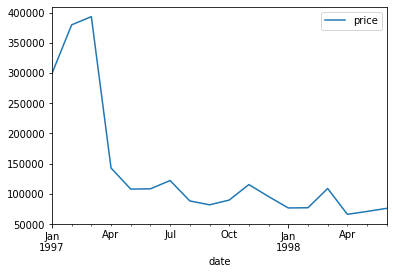

In [20]:
cdnow_df.reset_index().set_index('date')[['price']].resample(rule = "MS").sum().plot()

In [21]:
ids = cdnow_df['customer_id'].unique()

In [22]:
ids_selected = ids[0:10]

In [23]:
cdnow_cust_id_subset_df = cdnow_df\
    [cdnow_df['customer_id'].isin(ids_selected)]\
    .groupby(['customer_id', 'date'])\
    .sum().reset_index()

C:\Users\virus\Anaconda3\envs\cltv\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\virus\Anaconda3\envs\cltv\lib\site-packages\plotnine\utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
C:\Users\virus\Anaconda3\envs\cltv\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\virus\Anaconda3\envs\cltv\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
C:\Users\virus\Anaconda3\envs\cltv\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the

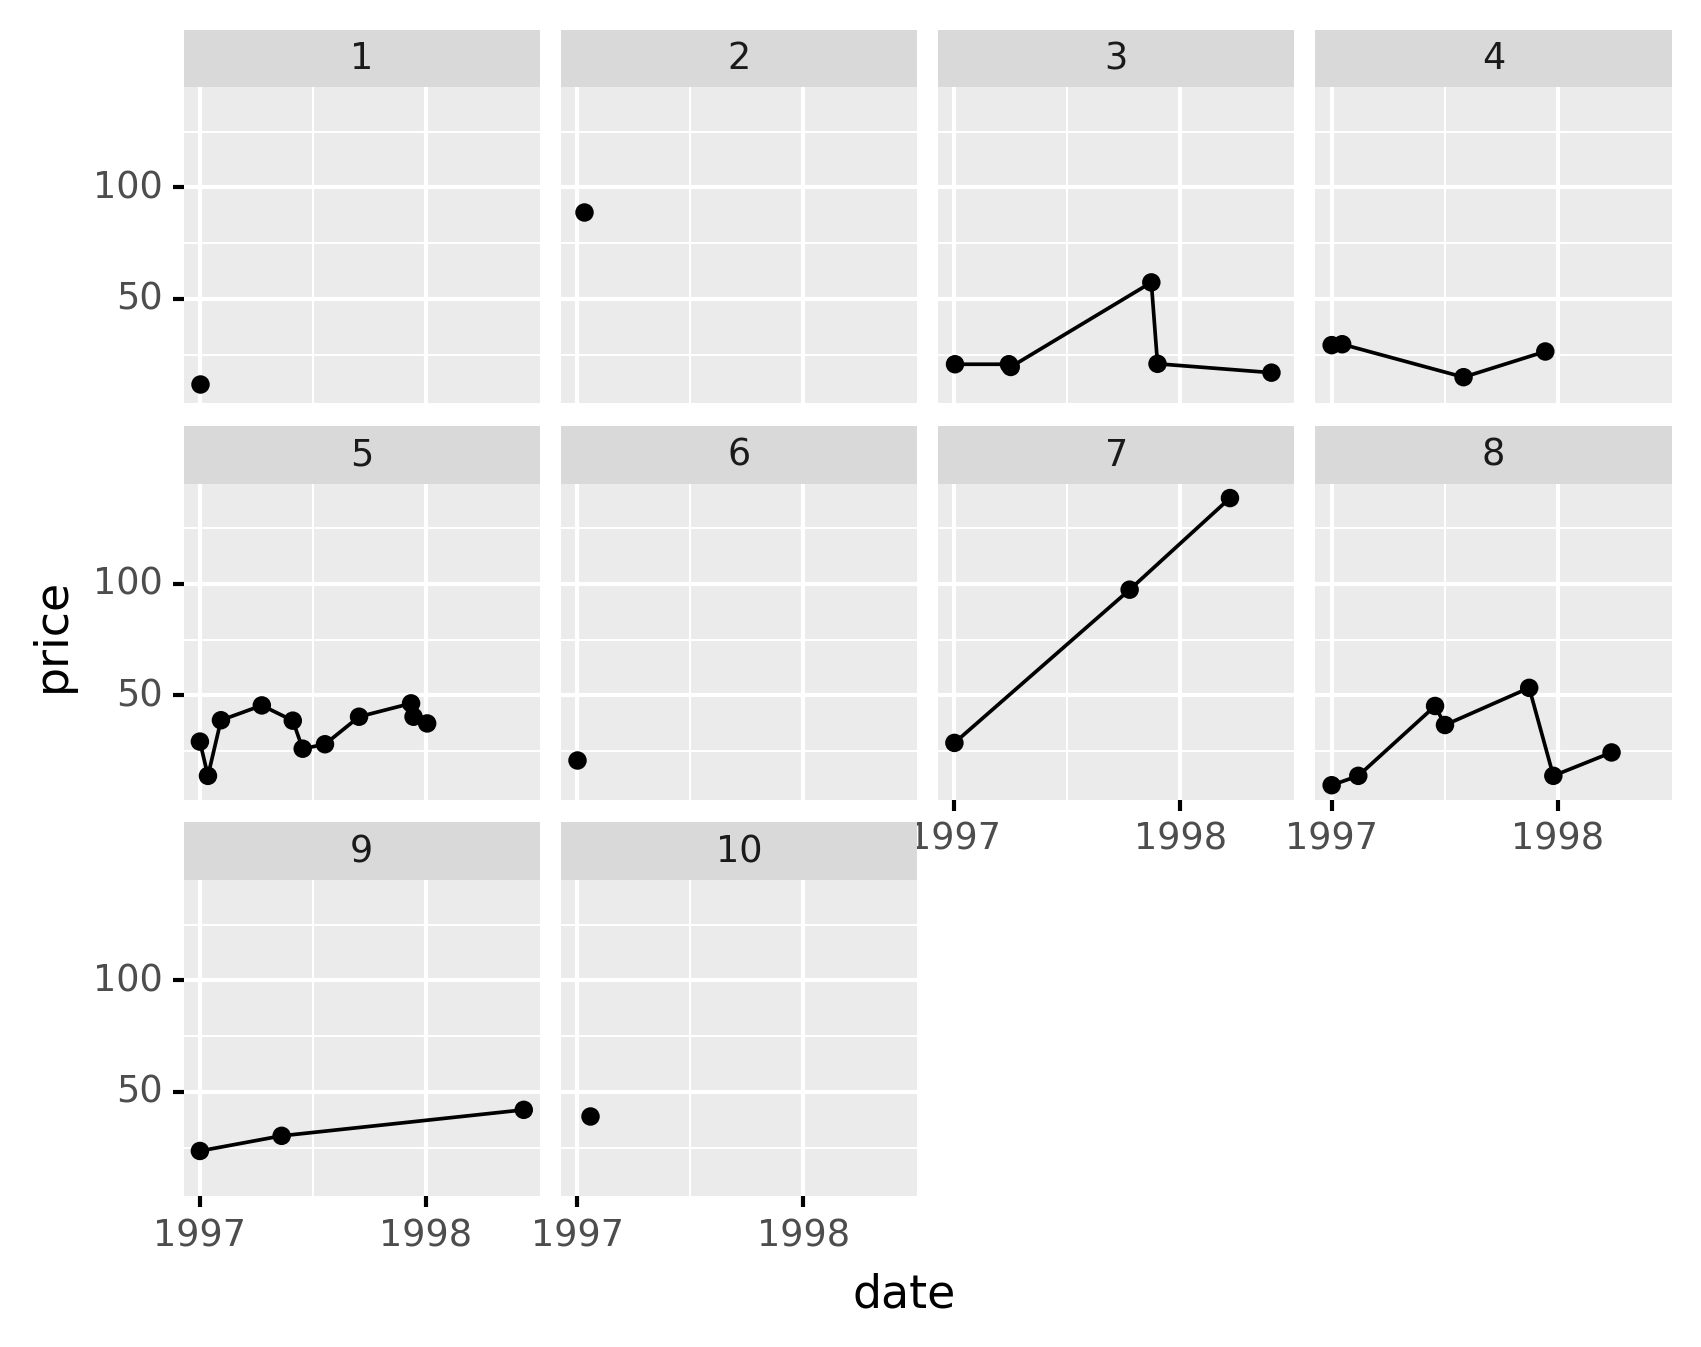

<ggplot: (90618079778)>

In [24]:
pn.ggplot(
    pn.aes('date', 'price', group = 'customer_id'),
    data = cdnow_cust_id_subset_df)\
    +pn.geom_line()\
    +pn.geom_point()\
    +pn.facet_wrap('customer_id')\
    +pn.scale_x_date(
        date_breaks = "1 year",
        date_labels = "%Y")

In [25]:
n_days = 90

In [26]:
max_date = cdnow_df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = "d")

In [27]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff ]

In [28]:
temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff ]

In [29]:
temporal_in_df

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76
...,...,...,...,...
69654,23568,1997-04-05,4,83.74
69655,23568,1997-04-22,1,14.99
69656,23569,1997-03-25,2,25.74
69657,23570,1997-03-25,3,51.12


In [30]:
temporal_out_df

,customer_id,date,quantity,price
8,3,1998-05-28,1,16.99
38,9,1998-06-08,2,41.98
68,25,1998-04-17,1,12.99
69,25,1998-05-25,1,10.49
70,25,1998-06-03,3,24.97
...,...,...,...,...
69583,23534,1998-05-02,1,10.48
69623,23555,1998-05-01,4,49.96
69624,23555,1998-06-10,2,27.48
69631,23556,1998-06-07,2,28.98


In [31]:
cutoff

Timestamp('1998-04-01 00:00:00')

In [32]:
targets_df = temporal_out_df.drop('quantity', axis = 1).groupby('customer_id').sum()\
.rename({'price': 'spend_90_total'}, axis=1).assign(spend_90_flag = 1)

In [33]:
targets_df

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [34]:
max_date = temporal_in_df['date'].max()

In [35]:
recency_features_df = temporal_in_df\
[['customer_id', 'date']]\
.groupby('customer_id')\
.apply(lambda x: (x['date'].max() - max_date) /pd.to_timedelta(1, "day"))\
.to_frame()\
.set_axis(["recency"],axis = 1)

In [36]:
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [37]:
recency_features_df = temporal_in_df\
[['customer_id', 'date']]\
.groupby('customer_id')\
.apply(lambda x: (x['date'].max() - max_date) /pd.to_timedelta(1, "day")).to_frame().set_axis(["recency"],axis = 1)

In [38]:
frequency_features_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id').count().set_axis(['frequency'], axis = 1)

In [39]:
frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [40]:
price_features_df = temporal_in_df\
 .groupby('customer_id').\
 aggregate(
  {
      'price':["sum", "mean"]
  }  
)\
.set_axis(['price_sum','price_mean'], axis = 1)

In [41]:
price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


In [42]:
 features_df = pd.concat([recency_features_df, frequency_features_df,price_features_df], axis = 1).merge(
            targets_df,
            left_index = True,
            right_index = True,
            how         = "left"
        
        )\
    .fillna(0)

In [44]:
features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


In [45]:
from xgboost import XGBClassifier, XGBRegressor


In [59]:
from sklearn.model_selection import GridSearchCV

In [65]:
X = features_df[['recency','frequency','price_sum']]

In [66]:
y_spend = features_df['spend_90_total']

In [50]:
y_spend.info()

<class 'pandas.core.series.Series'>
Int64Index: 23570 entries, 1 to 23570
Series name: spend_90_total
Non-Null Count  Dtype  
--------------  -----  
23570 non-null  float64
dtypes: float64(1)
memory usage: 884.3 KB


In [67]:
xgb_reg_spec = XGBRegressor(objective = "reg:squarederror", random_state=123)

In [68]:
xgb_reg_model = GridSearchCV(
    estimator = xgb_reg_spec,
    param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
    scoring = 'neg_mean_absolute_error',
    refit = True,
    cv = 5)

In [69]:
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [70]:
xgb_reg_model.best_score_

-9.799909748159553

In [71]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [72]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [88]:
predictions_reg = xgb_reg_model.predict(X)

In [73]:
y_prob = features_df['spend_90_flag']

In [77]:
xgb_clf_spec = XGBClassifier(
    objective = "binary:logistic",
    random_state = 123)

In [78]:
xgb_clf_model = GridSearchCV(
    estimator = xgb_clf_spec,
    param_grid=dict(learning_rate=[0.01, 0.1, 0.3, 0.5]),
    scoring = 'roc_auc',
    refit = True,
    cv = 5)

In [79]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [81]:
xgb_clf_model.best_score_

0.8347192483822283

In [82]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [83]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [87]:
predictions_clf = xgb_clf_model.predict_proba(X)

- *Save work*

In [91]:
predictions_df = pd.concat([
    pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis = 1),
    pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis = 1),
    features_df.reset_index()],
    axis = 1
)

In [92]:
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.758638,0.200422,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.695074,0.210225,2,-444.0,2,89.00,44.500000,0.00,0.0
2,9.016056,0.351506,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.547584,0.351896,4,-110.0,4,100.50,25.125000,0.00,0.0
4,16.620186,0.547565,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.866526,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.866526,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.286172,0.237482,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.866526,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0


In [93]:
predictions_df.to_pickle("assets/predictions_df.pkl")

In [109]:
x=pd.read_pickle('assets/predictions_df.pkl')

In [119]:
x[(x['spend_90_flag'] == 0) & (x['pred_prob']>0.7)]

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
364,27.304079,0.707509,365,-10.0,12,297.80,24.816667,0.0,0.0
1160,55.653954,0.732634,1161,-10.0,11,1244.34,113.121818,0.0,0.0
2952,70.924507,0.743025,2953,-6.0,12,732.73,61.060833,0.0,0.0
3162,27.304079,0.707509,3163,-7.0,15,377.30,25.153333,0.0,0.0
4158,81.154907,0.754680,4159,-4.0,36,931.68,25.880000,0.0,0.0
4239,70.924507,0.732634,4240,-8.0,11,755.19,68.653636,0.0,0.0
5054,79.685425,0.754680,5055,-8.0,20,797.11,39.855500,0.0,0.0
7322,88.830643,0.754680,7323,-10.0,22,827.28,37.603636,0.0,0.0
10612,54.982086,0.737472,10613,-3.0,13,523.72,40.286154,0.0,0.0
11710,19.224258,0.707509,11711,-5.0,13,227.20,17.476923,0.0,0.0


2. **Save model**

In [101]:
joblib.dump(xgb_reg_model, 'assets/xgb_reg_model.pkl')

['assets/xgb_reg_model.pkl']

In [102]:
joblib.dump(xgb_clf_model, 'assets/xgb_clf_model.pkl')

['assets/xgb_clf_model.pkl']

In [103]:
model = joblib.load('assets/xgb_reg_model.pkl')

In [104]:
model.predict(X)

array([0.7586377 , 1.6950741 , 9.016056  , ..., 3.2861717 , 0.86652637,
       2.1633224 ], dtype=float32)